In [1]:
import numpy as np
from alertstack.analyse import Analyse
from alertstack.scramble_catalogues.blazar_catalogue import Fermi4FGLBlazarCatalogue, AverageFluxWeightHypothesis
from alertstack.fixed_catalogues.icecube_neutrino_alerts import CircularisedNeutrinoAlertCatalogue
# from alertstack.stats import C hi2

In [2]:
ana = Analyse(
    Fermi4FGLBlazarCatalogue(),
    [AverageFluxWeightHypothesis],
    CircularisedNeutrinoAlertCatalogue()
)

NSIDE = 1024, Max Pixel Radius = 0.059800825955419704 deg


In [51]:
all_res = ana.iterate_run(n_trials=5000, injection_hypo=AverageFluxWeightHypothesis, fraction=0.2, nsteps=5)

sens_threshold = dict()
disc_threshold = dict()

zero_key = 0.0

for key, val in all_res[zero_key].items():
    sens_threshold[key] = np.median(val)
    # print(Chi2(val))
    # input("?")

100%|██████████| 5000/5000 [00:59<00:00, 83.74it/s]


In [52]:
for step, res in all_res.items():
    print("Fraction of neutrino alerts correlated to source: {0} \n".format(step))

    bkgs = dict()

    for key, val in res.items():
        print(key, np.mean(val), np.median(val), np.std(val))
        val = np.array(val)
        print("Fraction above median background:", np.sum(val > sens_threshold[key])/float(len(val)))

Fraction of neutrino alerts correlated to source: 0.0 

average_flux_weight -0.17534930330124265 -0.22644303680475164 0.5571810038539048
Fraction above median background: 0.5
Fraction of neutrino alerts correlated to source: 0.04 

average_flux_weight 0.44199452910740966 0.32390496271107394 0.8333494755531238
Fraction above median background: 0.7794
Fraction of neutrino alerts correlated to source: 0.08 

average_flux_weight 0.8665851118982202 0.7932061059234594 0.8745231637696592
Fraction above median background: 0.9078
Fraction of neutrino alerts correlated to source: 0.12 

average_flux_weight 1.1834051593513966 1.1374687516328716 0.8499939563061892
Fraction above median background: 0.9626
Fraction of neutrino alerts correlated to source: 0.16 

average_flux_weight 1.4616023308614563 1.4318488716055109 0.8083153681236032
Fraction above median background: 0.9884
Fraction of neutrino alerts correlated to source: 0.2 

average_flux_weight 1.669914876416405 1.6737460063187353 0.76356916

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

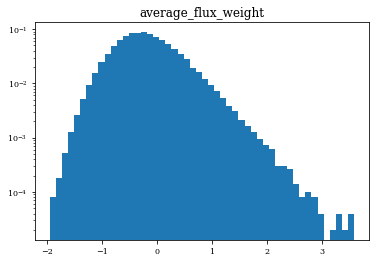

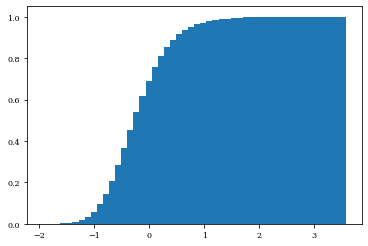

In [58]:
for key, val in all_res[zero_key].items():
    weights = np.ones_like(val)/float(len(val))
    plt.hist(val, weights=weights, bins=50)
    plt.title(key)
    plt.yscale("log")
    plt.figure()
    plt.hist(val, weights=weights, cumulative=True, bins=50)

      fun: 40644.77992394106
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00654836, -0.034197  ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 16
   status: 0
  success: True
        x: array([9.85016282, 0.17994937])
3 sigma Discovery Potential: 3.950734800555365
5 sigma Discovery Potential: 6.141594588366258


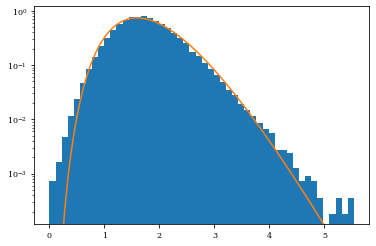

In [153]:
import scipy
from scipy.stats import norm

# class GammaDist:
    
#     def __init__(self, data):


for key, val in all_res[zero_key].items():
    
    data = val - min(val) + 1e-9
    weights = np.ones_like(data)/float(len(data))
    mask = np.ones_like(data, dtype=np.int)

    # three parameters will be fitted: dof, location, scale
    p_start = [9., 0.5]
    p_bounds = [(0, None), # dof > 0
                (1e-5, 1e5)
               ]

    # define the fit function: likelihood for chi^2 distribution,
    def func(p):
        dist = scipy.stats.gamma(p[0], loc=0., scale=p[1])
        loglh = dist.logpdf(data).sum()
        return -loglh

    res = scipy.optimize.minimize(func, x0=p_start, bounds=p_bounds)
    print(res)
    plt.hist(data, density=True, bins=50)
    x_range = np.linspace(min(data), max(data), 100)
#     plt.plot(x_range, scipy.stats.gamma.pdf(x_range, res["x"][0], loc=0., scale=res["x"][1]))
    plt.yscale("log")
    ylim = plt.gca().get_ylim()
    res_f = scipy.stats.gamma(res["x"][0], loc=0., scale=res["x"][1])
    plt.plot(x_range, res_f.pdf(x_range))
    plt.gca().set_ylim(ylim)
    
    disc_threshold = res_f.ppf(raw_five_sigma)
    
    for i in [3, 5]:
        disc_threshold = res_f.ppf(norm.cdf(i))
        print("{0} Sigma Discovery Potential: {1}".format(i, disc_threshold))